# Pauli Spin Blockade

Using new functions in `august/paul.py` and `august/shfqc.py` to make this notebook easier to work with.


In [14]:
%matplotlib inline
import local_broom

In [15]:
# Automagically reload modules when they are edited
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from qcodes import Instrument, Station
from monty import Monty
import MDAC
from may.dots import getvoltages
from may.custom_devices import connect_to_gb, newSiDot
from liveplot import LivePlot
from fridge import Fridge
import paul
from shfqc import SHFQC
from monty import Monty
import time
import logging

## Setup

In [17]:
channels = ["ST", "P1", "P2", "J"]
channel_addr = [0, 1, 2, 3]

shfqc = SHFQC(channels, channel_addr, "measure")

In [18]:
shfqc.connect()

try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')

try:
    lockin = Instrument.find_instrument("sr860_top")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name sr860_top. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

lockin = scfg.load_instrument('sr860_top')



gb_control_si = connect_to_gb(mdac)  # Create our custom MDAC mappings
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Connecting to device DEV12158
Creating new command tables
Attempting to remove instrument with name mdac. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.20s
Cannot remove instrument with name sr860_top. Does not exist
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.14s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [19]:
# Disconnect from all devices
disconnect = False
if disconnect:
    shfqc.disconnect()
    try:
        mdac = Instrument.find_instrument("mdac")
        mdac.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')
    try:
        lockin = Instrument.find_instrument("sr860_top")
        lockin.close()
    except KeyError:
        print("Cannot remove instrument with name sr860_top. Does not exist")

In [20]:
# setup monty
experiment = {
    "desc": "Run detuning and J sweeps to see pauli spin blockade"
}

monty = Monty("rf.psb_best", experiment)

Started new experiment rf.psb_best


### Define parameters

In [33]:
params = {
    "amplitude_volts": {  # define the amplitudes that should be used. (maximum 340mV, give in Volts)
        "mixed_pulse": {  # voltage amplitude for mixed state preperation
            "P1": -0.2,  # make sure keys match drive lines above
            "P2": 0.2,
        },
        "measure_pulse_start": {  # voltages for stepping over when sweeping
            "P1": 0.0,
            "P2": -0.0,
            "J": 3.35,
        },
        "measure_pulse_end": {
            "P1": -0.006,
            "P2": 0.006,
            "J": 3.75,
        },
        "ramp_rate": 13e-5,  # V/sample
    },
    "readout": {
        "freq": 406.6e6,  # (Hz) try 406.2e6
        "gain": 0.95,  # If we set this to 1, then output overloads
        "time": 100e-6,  # sec
    },
    "timings_sec": {  # all in seconds
        "mixed_initilise": 600e-6,
        "read": 100e-6,
        "settle": 3e-3,
        "trigger": 8e-3,  # metronome of the internal trigger
        "buffer": 10e-6,
        "sampling_divider": 6,  # playback waveform resolution 2^X
    },
    "feedback": {
        "target": -24.1,  # in dB
        "stepsize": 2e-2,  # arbitrary units
        "slope": -0,  # -1, 1 depending on slope, 0 to disable feedback
    },
    "powers": {  # in dB presets from UI
        "acq_in": 0,
        "acq_out": -10,
        "drive": 0,  # only 0 is supported
    },
    "averaging": {
        "seqc_averages": 1000,  # max 2**19 points
        "num_detuning": 100,
        "num_j": 70,
    },
    "gates": getvoltages(mdac),
    "temp": f"Mixing chamber {fridge.temp()} K",
}


# Dynamic variables
# create arrays of our sweeping paramters
j_steps = np.linspace(params["amplitude_volts"]["measure_pulse_start"]["J"],
                      params["amplitude_volts"]["measure_pulse_end"]["J"],
                      params["averaging"]["num_j"])
p1_steps = np.linspace(params["amplitude_volts"]["measure_pulse_start"]["P1"],
                       params["amplitude_volts"]["measure_pulse_end"]["P1"],
                       params["averaging"]["num_detuning"])
p2_steps = np.linspace(params["amplitude_volts"]["measure_pulse_start"]["P2"],
                       params["amplitude_volts"]["measure_pulse_end"]["P2"],
                       params["averaging"]["num_detuning"])

## Run functions

In [34]:
def sweep_j_and_detuning():
    """2D parameter sweep of J and P1/P2 in detuning setup. Can measure PSB if mixed state preperation amplitude is not zero"""
    monty.newrun("j_and_detuning", params)

    # setup channels to match parameters
    paul.setupchannels(shfqc, params)
    paul.setupsequencers(shfqc, params, print_programs=False)
    paul.setup_command_tables(shfqc, params)
    time.sleep(1)  # wait to make sure everything processed in time

    # work out what we should be doing for feedback
    print("Measuring initial feedback point")
    paul.synchchannels(shfqc, [shfqc.qa_channel_name])
    with shfqc.device.set_transaction():
        
        shfqc["measure"].spectroscopy.result.length(1)
        seqc_program_prior_read = f"""
            repeat({params["averaging"]["seqc_averages"]}) {{
                waitDigTrigger(1);
        
                setTrigger(1);
                setTrigger(0);
            }}
            """
        shfqc["measure"].generator.load_sequencer_program(seqc_program_prior_read)
    
    time.sleep(1)
    shfqc["measure"].spectroscopy.result.length.wait_for_state_change(1, timeout=10)  # wait for changes to propagate
    
    data = paul.run_empty_experiment(shfqc)

    # run the real experiment
    paul.synchchannels(shfqc, [shfqc.qa_channel_name] + shfqc.drive_channels)
    paul.setupsequencers(shfqc, params, print_programs=False)  # reload original QA code
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_j"], params["averaging"]["num_detuning"], 2), dtype=np.complex64)
    st_result = np.zeros(result.shape, dtype=np.float64)
    
    print("Sweeping P1, P2 and J")
    for i, j in enumerate(tqdm(j_steps, desc="J")):
        #with LivePlot(p1_steps, xlabel="P1 voltage (dV)", ylabel="Amplitude (dB)") as lplot: 
        
        for k, (p1, p2) in enumerate(zip(tqdm(p1_steps, leave=False, desc="Detuning"), p2_steps)):
            paul.movemeasurement(shfqc, p1, p2, j, params)  # Use cmd index = 1
            #st_result[i, k] = paul.calculate_feedback(shfqc, data[-1], params)  # cmd index = 0
            paul.upload_command_tables(shfqc)
            data = paul.run_psb_experiment(shfqc)
            result[i, k] = data
            #lplot.update(autodb(result[i, :, 1]))
        monty.snapshot({"data": result, "st_result": st_result})

    results = {"data": result, "st_result": st_result}
    monty.save(results)
    return results

In [37]:
def hyper_j_sweep():
    """
    Sweep j and detuning quickly by offloading as much as possible on the SHFQC device.
    Unforrtunately in this regime it is impossible to do feedback during detuning (although it can be done over J)
    """
    monty.newrun("hyper_j", params)

    if "feedback" in params.keys():
        logging.warning("Feedback specified in params but not used in this experiment")

    # setup channels for hyper sweeps
    paul.setupchannels(shfqc, params, hyper=True)
    paul.setup_hyper_sequencers(shfqc, params, print_programs=False)
    paul.setup_hyper_command_tables(shfqc, params)
    
    # run the real experiment
    paul.synchchannels(shfqc, [shfqc.qa_channel_name, "P1", "P2", "J"])
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_j"], params["averaging"]["num_detuning"]*2), dtype=np.complex64)
    
    print("Sweeping J (python), P1/P2 (seqc)")
    for i, j in enumerate(tqdm(j_steps, desc="J")):
        gb_control_si.VICL(j)
        gettotarget()
        time.sleep(1)
        #paul.move_j_measurement(shfqc, j, params)
        paul.upload_command_tables(shfqc)
        result[i, :] = paul.run_hyper_psb_experiment(shfqc)
        # update J command table
        monty.snapshot({"data": result})

    results = {"data": result}
    monty.save(results)
    return results
    

In [ ]:
# results = sweep_j_and_detuning()
results = hyper_j_sweep()

Started new run hyper_j
Sweeping J (python), P1/P2 (seqc)


J:   0%|          | 0/70 [00:00<?, ?it/s]

Target = 9.0000e-11, tol = 1e-12, initial ST = 3.679737
ST = 3.6797e+00, lockin = 8.9718e-11, delta = 2.4120e-13
Final ST = 3.679727


Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print(j_steps)

In [22]:
gb_control_si.VICL(3.35)

In [ ]:
# The best way to not fuck up the results like last time is to just run it a bunch of times. I am so sorry.

j_start = 3.2
j_stop = 4
j_steps_dc = 60  # ~ 15 minutes per run, should equal overnight

j_sweep = np.linspace(j_start, j_stop, j_steps_dc)

for v_j in j_sweep:

    gb_control_si.VICL(v_j)
    time.sleep(1)
    gettotarget()
    time.sleep(1)
    results = hyper_j_sweep()

In [ ]:
# PLOTTING FUNCTIONS SHOULD ALL BE DONE IN pauli_plots.ipynb

In [ ]:
gb_control_si.VICL(3.5)

Started new run SET_ST_sweep
Sweeping Si28_quantum_dot_ST from 3.6V to 3.7V in 101 points.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:40<00:00,  2.48it/s]


Run finished and took 0:00:46.137473.
Saving to SET_ST_sweep.xz
Saving to experiment.yaml


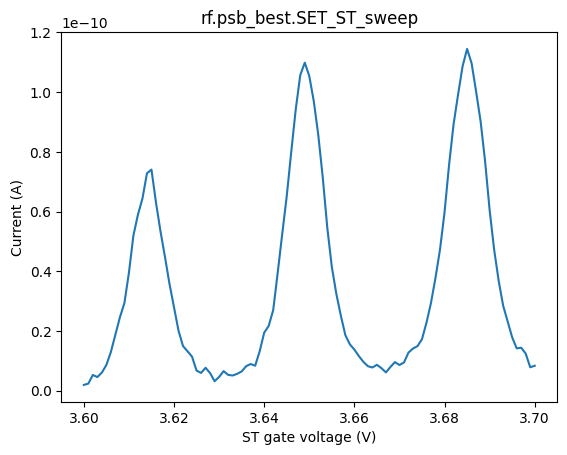

In [23]:
import swiper

low = 3.6
high = 3.7
pts = 101

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty)  # overlap points so we average

monty.save(result)

In [25]:
si.ST(3.68)

In [26]:
#si.ST(3.68)
target = 0.9e-10  # choose slightly on the right to match 
tol = 0.01e-10

def feedback(gate, lockin, target: float, stepsize=0.001, slope="up"):
    """
    Apply proportional feedback blindly
    """
    if slope == "up":
        sgn = 1
    elif slope == "down":
        sgn = -1
    else:
        raise (f"Unknown slope '{slope}'. Must be either 'up' or 'down'")

    r = lockin.R()
    error = (target - r) * sgn
    adjust = error / target * stepsize  # normalised error func
    g = gate() + adjust  # new gate voltage

    upperbound = 3.8
    lowerbound = 3.3

    if g > upperbound:  # upper bound
        print(f"Aborting feedback: correction voltage exceeds threshold, {g} > {upperbound}. No change to ST.")
    elif g < lowerbound:  # lower bound
        print(f"Aborting feedback: correction voltage fails to meet threshold, {g} < {lowerbound}. No change to ST.")
    #elif np.abs(r-target) > 0.03e-10:  # take a small step if good
    #    print(f"small step {np.abs(r-target)}")
    #    gate(gate() + adjust/4)
    #    time.sleep(0.5)
    else:
        gate(g)
        time.sleep(0.5)

def gettotarget():  # inherit global variables (bad!!!!)
    print(f"Target = {target:.4e}, tol = {tol}, initial ST = {si.ST()}")
    while np.abs(lockin.R()-target) > tol:
        feedback(si.ST, lockin, target, stepsize=0.001, slope="up")
        print(f"\rST = {si.ST():.4e}, lockin = {lockin.R():.4e}, delta = {np.abs(lockin.R()-target):.4e}", end="")
        time.sleep(0.1)
    print(f"\nFinal ST = {si.ST()}")

In [27]:
si.ST(3.68)
gettotarget()

Target = 9.0000e-11, tol = 1e-12, initial ST = 3.680002
ST = 3.6797e+00, lockin = 8.8858e-11, delta = 1.1328e-12
Final ST = 3.679737


In [28]:
gb_control_si.VICL()

3.35002

In [ ]:
for c in shfqc.drive_channels:
    if c != "J":
        print(c)
    else:
        print(c + "hello")